In [22]:
##Ridge regression 

import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.ml as ml  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y, 0.8);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [24]:
id_angle = [15, 18, 20, 25, 28]
id_nan = [0, 24, 27]
x_train, header = ml.augmented_feat_angle(x_train, id_angle, header)
#x_train, header = ml.add_nan_feature(x_train, id_nan, header)

for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.0440, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 595.8190]
Feature 3 - DER_mass_vis has range: [6.4620, 1329.9130]
Feature 4 - DER_pt_h has range: [0.0000, 1053.8070]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [13.6020, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6900]
Feature 8 - DER_deltar_tau_lep has range: [0.2080, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 513.6590]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 622.8620]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 461.8960]
Fea

In [25]:
dim = x_train.shape[1]
m_b = np.zeros((dim, dim))
m_s = np.zeros((dim, dim))
m_d = np.zeros((dim, dim))

for i, f1 in enumerate(x_train.T):
    for j, f2 in enumerate(x_train.T):
        if i == j:
            f_res = f1
        else:
            f_res = f1*f2
        id_keep = ~np.isnan(f_res)
        id_b = np.logical_and(y_train == -1, id_keep)
        id_s = np.logical_and(y_train == 1, id_keep)
        f_norm = (f_res-np.nanmean(f_res))/np.nanstd(f_res)
        m_b[i,j] = np.median(f_norm[id_b])
        m_s[i,j] = np.median(f_norm[id_s])
        m_d[i,j] = np.median(f_norm[id_b]) - np.median(f_norm[id_s])

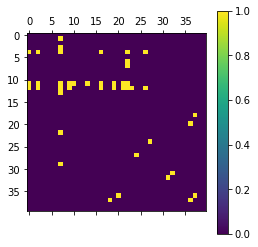

In [29]:
plt.figure(figsize=(16, 4))
plt.matshow(np.abs(m_d)-np.abs(np.diag(m_d)) > 0.4)
plt.colorbar()
plt.show()

In [30]:
from collections import Counter

tresh_id = np.nonzero((np.abs(m_d)-np.abs(np.diag(m_d))).flatten() > 0.4)
res = np.unravel_index(tresh_id, (dim, dim))
combs = np.array(res).reshape((2,-1)).T

# Take only unique pairs
combs = np.sort(combs, axis=1)
combs = list(set([tuple(row) for row in combs]))

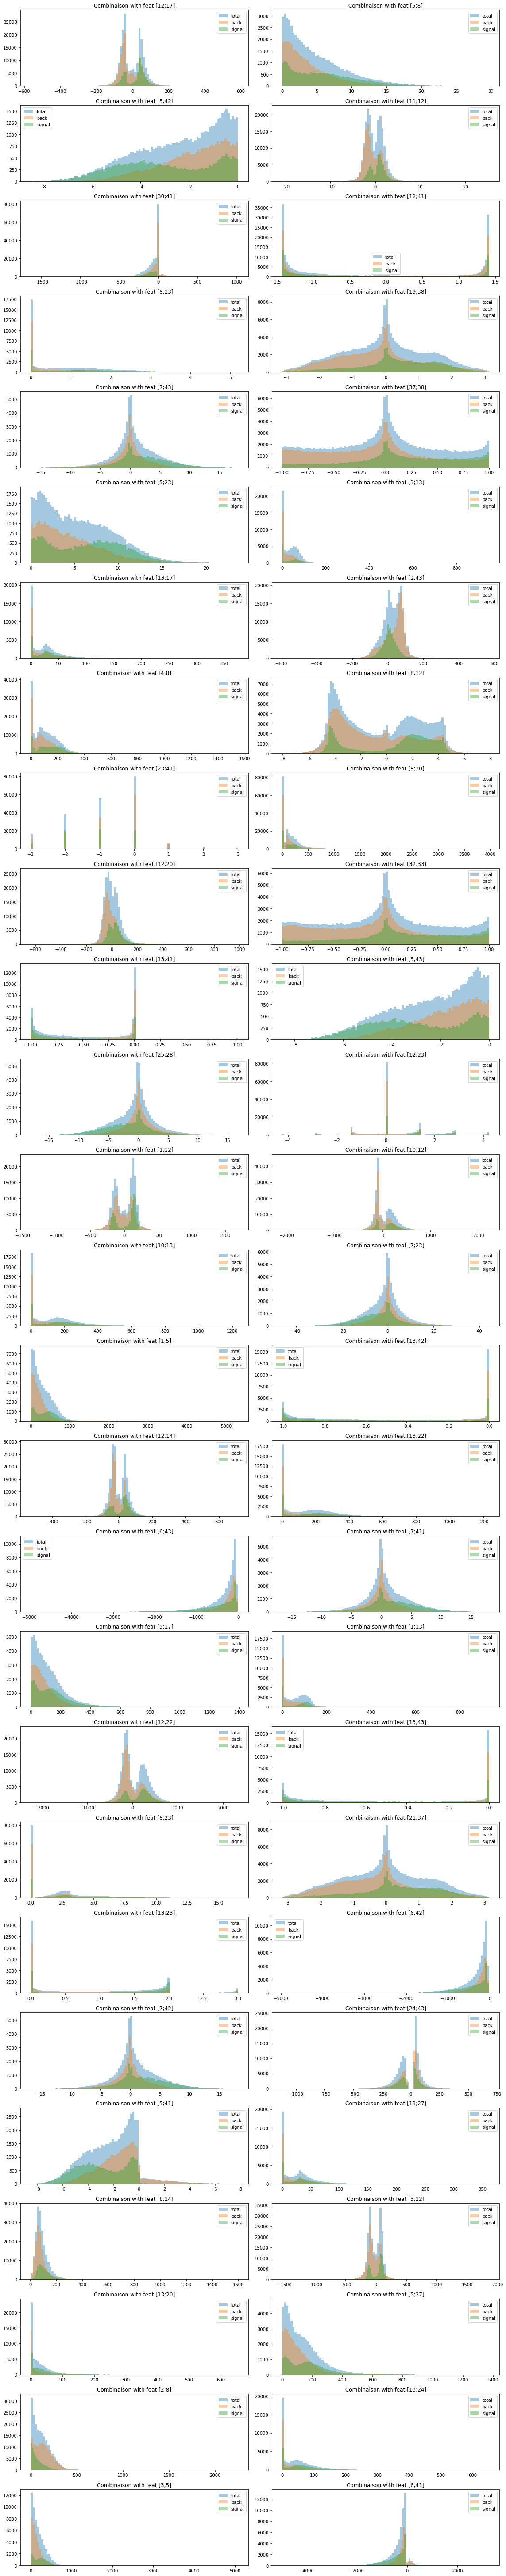

In [16]:
n_lines = np.ceil(len(combs)/2)
plt.figure(figsize=(16, 3*n_lines))

for i, comb in enumerate(combs):
    plt.subplot(n_lines, 2, i+1)
    
    f1 = x_train[:, comb[0]]
    f2 = x_train[:, comb[1]]
    ft = f1*f2

    id_keep = ~np.isnan(ft)
    id_b = np.logical_and(y_train == -1, id_keep)
    id_s = np.logical_and(y_train == 1, id_keep)

    plt.hist(ft[id_keep], bins=100, alpha=0.4, label='total')
    plt.hist(ft[id_b], alpha=0.4, bins=100, label='back')
    plt.hist(ft[id_s], alpha=0.4, bins=100, label='signal')
    plt.title('Combinaison with feat [{};{}]'.format(comb[0]+1, comb[1]+1))
    plt.legend()

plt.tight_layout()
plt.show()

In [20]:
def add_feature(x_in, id_feat1, id_feat2):
    new_feat = np.expand_dims(x_in[:, id_feat1]*x_in[:, id_feat2], axis=1)
    return np.concatenate((x_in, new_feat), axis=1)

def add_features(x_in, id_feats):
    for id_feat in id_feats:
        x_in = add_feature(x_in, id_feat[0], id_feat[1])
    return x_in

add_feature(x_train, 3, 7).shape
add_features(x_train, [[3, 7],[3, 4]]).shape

(200000, 45)

In [31]:
combs

[(11, 16),
 (4, 7),
 (10, 11),
 (7, 12),
 (36, 37),
 (18, 37),
 (4, 22),
 (2, 12),
 (12, 16),
 (7, 11),
 (3, 7),
 (7, 29),
 (31, 32),
 (11, 19),
 (24, 27),
 (11, 22),
 (0, 11),
 (9, 11),
 (6, 22),
 (0, 4),
 (11, 13),
 (12, 21),
 (4, 16),
 (0, 12),
 (11, 21),
 (7, 22),
 (20, 36),
 (12, 22),
 (12, 26),
 (7, 13),
 (2, 11),
 (12, 19),
 (4, 26),
 (1, 7),
 (12, 23),
 (2, 4),
 (9, 12)]